# **Network Dynamics: Homework III**
## Andrea Silvi (s290312), Politecnico di Torino
## andrea.silvi@studenti.polito.it


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import math

# Problem 1

We first generate a symmetric k-regular graph and simulate 15 week of en epidemic on it.

In [15]:
n_nodes = 500
rng = default_rng()

G = nx.cycle_graph(n_nodes) # start from a cyclic graph
k = 4 # note: k should be even

for n in range(n_nodes): 
    for i in range(1, int(k/2+1)):  # we add edges between node n and the k/2 previous nodes + node n and the k/2 next nodes 
        G.add_edge(n,((n+i) % n_nodes))
        G.add_edge(n,((n-i) % n_nodes))

We present an algorithm that simulates an epidemic over *n_weeks* weeks on a given Graph, with given parameters $\beta$ and $\rho$, starting from *starting_infected* randomly selected people. It is also possible to consider vaccinations and pass a vector of percentage of vaccinated over the weeks and the starting number of people vaccinated.

In [2]:
def simulate_epidemics(n_weeks, beta, rho, G, starting_infected,
                       vaccinations=False, n_vax_per_week=None, starting_vaxxed=None):
    history = np.zeros((3, 16)) 
    hist_newly_infected = np.zeros(16)
    W = nx.adjacency_matrix(G)
    n_nodes = G.number_of_nodes()
    n_weeks = n_weeks
    
    n_infected = starting_infected # the number of starting infected
    history[0, 0] += n_nodes - n_infected #we save in row 0 the susceptibles
    history[1, 0] += n_infected # in row 1 the infected
    hist_newly_infected[0] += n_infected # the newly infected
    infected = rng.choice(np.arange(n_nodes), size=n_infected, replace=False) #we randomly pick without replacement the starting infected
    x_previous_week = np.zeros(n_nodes, dtype=int)
    x_previous_week[infected] = 1 # saves for each node its status in the previous week
    x = np.zeros(n_nodes, dtype=int) # saves for each node the new status in that week
    if vaccinations: # when True, distribute first round of vaccines 
        non_vaccinated = np.ones(n_nodes) # at the start everyone is non vaccinated
        vaccinated = distribute_vaccines(candidates = np.arange(n_nodes),
                                         n_vaccines = starting_vaxxed*n_nodes/100)   #calculate the number of starting vaccinated
        x[vaccinated] = 2 # they are recovered
        x_previous_week[vaccinated] = 2
        non_vaccinated[vaccinated] = 0 # they also are not anymore not vaccinated
    for week in range(1, n_weeks+1): # from week 1 to week 15
        if vaccinations: # distribute vaccines
            # we consider only people that are yet to be vaccinated
            vaccinated = distribute_vaccines(candidates = np.nonzero((non_vaccinated==1))[0],
                                         n_vaccines = n_vax_per_week[week-1]*n_nodes/100) 
            x[vaccinated] = 2 # considered as recovered
            x_previous_week[vaccinated] = 2 # instantaneously recovered, so also previous week are recovered
            non_vaccinated[vaccinated] = 0  # cannot be vaccinated anymore
        n_infected = (x_previous_week == 1).sum()
        infected = np.nonzero(x_previous_week == 1)[0] # find the infected
        infected_neighbours = W[:, infected] @ np.ones(n_infected) # find for each person the number of infected neighbours
        susceptibles = np.nonzero(x_previous_week==0)[0] # find the susceptible
        for s in susceptibles:
            p_no_infection = (1-beta)**infected_neighbours[s] #prob. of not getting infected
            x[s] = rng.choice([0, 1], p=[p_no_infection, (1-p_no_infection)]) # find if infection occurs
            if x[s] == 1:
                hist_newly_infected[week] += 1
        for i in infected:
            p_no_recovery = 1 - rho
            x[i] = rng.choice([1, 2], p=[p_no_recovery, (1-p_no_recovery)]) # find if recovery occurs
        # save susceptible, infected, recovered
        history[0, week] = (x == 0).sum() 
        history[1, week] = (x == 1).sum()
        history[2, week] = (x == 2).sum()
        x_previous_week = x
    return history, hist_newly_infected

We simulate 100 simulations on the symmetric k-regular graph and average the results.

In [16]:
history = np.zeros((3, 16))
hist_newly_infected = np.zeros(16)
n_simulations = 100
for n in range(n_simulations):
    h, h_ni = simulate_epidemics(n_weeks=15, beta=0.3, rho=0.7, G=G, starting_infected=10)
    history = history + h
    hist_newly_infected = hist_newly_infected + h_ni
# save the average results from 100 simulations
history = history/n_simulations
hist_newly_infected = hist_newly_infected/n_simulations

In [3]:
def plot_newly_infected(hist_newly_infected, true_infected = None, vaxxed = None):
    fig, ax = plt.subplots(figsize=(10,10))
  
    if true_infected != None:
        ax.plot(np.arange(len(hist_newly_infected)), hist_newly_infected, label='predicted newly infected')
        ax.plot(np.arange(len(hist_newly_infected)), true_infected, label='true newly infected')
        ax.legend(loc='best', fancybox=True, frameon=True, fontsize=12)
    elif vaxxed != None:
        ax.plot(np.arange(len(hist_newly_infected)), hist_newly_infected, label='predicted newly infected')
        ax.plot(np.arange(len(hist_newly_infected)), vaxxed, label='newly vaccinated')
        ax.legend(loc='best', fancybox=True, frameon=True, fontsize=12)
    else:
        ax.plot(np.arange(len(hist_newly_infected)), hist_newly_infected)
    ax.set_xlabel('week', fontsize=16)
    ax.set_ylabel('Number of people newly infected', fontsize=16)

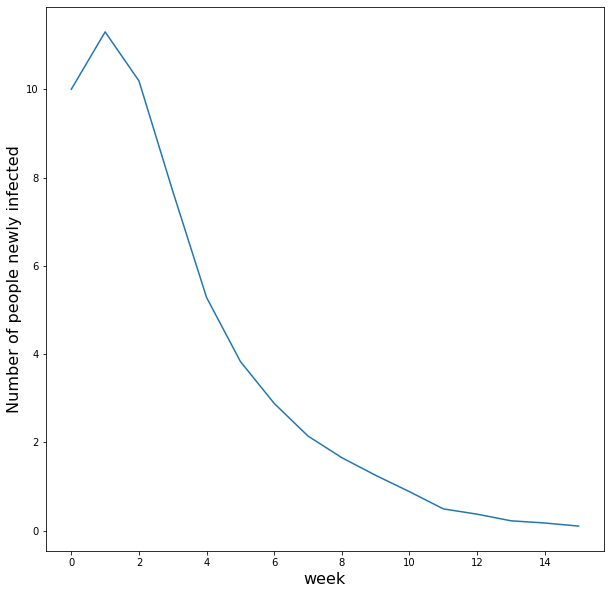

In [18]:
 plot_newly_infected(hist_newly_infected)

In [4]:
def plot_history_epidemics(history, vaxxed = None):
    fig, ax = plt.subplots(figsize=(10,10))
    states = {0: 'susceptibles', 1:'infected', 2:'recovered'}
    for i in [0, 1, 2]:
        status = str(states[i])
        ax.plot(np.arange(history.shape[1]), history[i, :], label=status)
    if vaxxed != None:
        ax.plot(np.arange(history.shape[1]), vaxxed, label='vaccinated')
    ax.legend(loc='best', fancybox=True, frameon=True, fontsize=12)
    ax.set_xlabel('week', fontsize=16)
    ax.set_ylabel('Number of people', fontsize=16) 

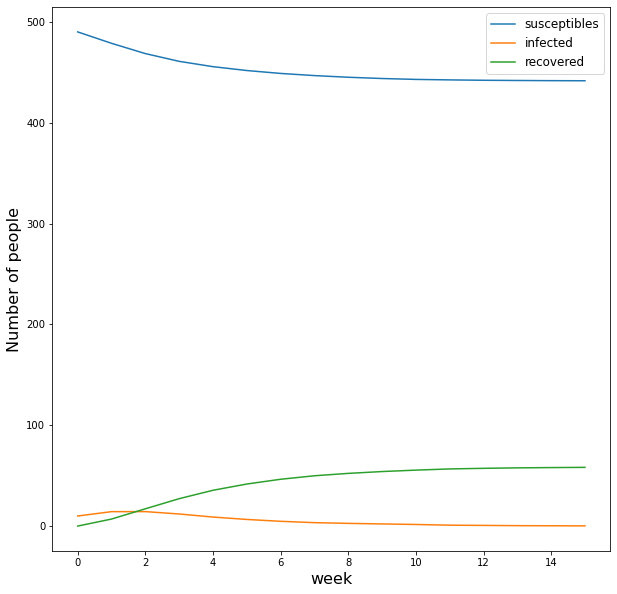

In [20]:
plot_history_epidemics(history)

We present an algorithm to generate a graph with k as average degree following the preferential attachment model.

In [5]:
def generate_preferential_attachment_graph(k, n_nodes): # k is average degree of the graph
    GPA = nx.complete_graph(k+1) # start from a complete graph of k+1 nodes
    for new_node in range(k+1, n_nodes): # add 1 node until n_nodes
        degrees = np.array([d for n, d in GPA.degree()]) # find degree distribution of current graph
        deg_distr = degrees/np.sum(degrees)
        c = math.floor(k/2) if new_node%2 == 0 else math.ceil(k/2) # if k even add k/2 links from new node, if odd alternate
                                                                   # between 1 less and 1 more
        neighbours = rng.choice(np.arange(GPA.number_of_nodes()), size=c, 
                                replace=False, p=deg_distr) # randomly pick without replacement 
                                                            # c nodes proportionally to their degree distr
        for neigh in neighbours:
            GPA.add_edge(new_node, neigh) # add link
    return GPA

In [23]:
k = 6
n_nodes = 900
GPA = generate_preferential_attachment_graph(6, 900)

In [24]:
print(f'Average degree of graph GPA (number of nodes = {n_nodes}, k = {k}): {np.average(np.array([d for n, d in GPA.degree()]))}.')

Average degree of graph GPA (number of nodes = 900, k = 6): 6.0.


# Problem 2
We average 100 simulations each time generating firstly a new graph with k = 6 following preferential attachment.

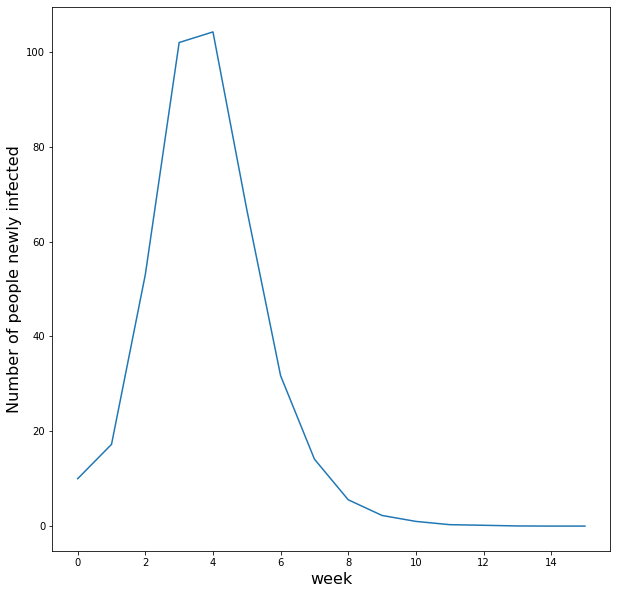

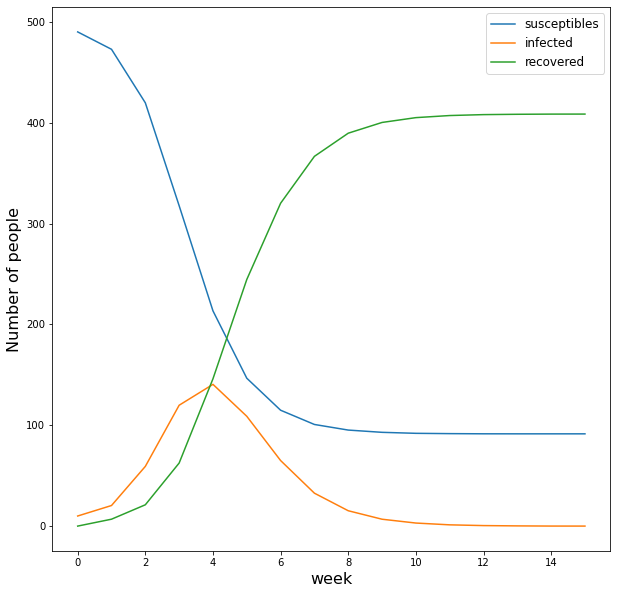

In [25]:
history = np.zeros((3, 16))
hist_newly_infected = np.zeros(16)
n_simulations = 100
for n in range(n_simulations):
    GPA = generate_preferential_attachment_graph(6, 500)
    h, h_ni = simulate_epidemics(n_weeks=15, beta=0.3, rho=0.7, G=GPA, starting_infected=10)
    history = history + h
    hist_newly_infected = hist_newly_infected + h_ni
history = history/n_simulations
hist_newly_infected = hist_newly_infected/n_simulations
plot_newly_infected(hist_newly_infected)
plot_history_epidemics(history)

# Problem 3
We now introduce the concept of vaccinations. 

In [6]:
vaxxed = np.array([0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60])

def distribute_vaccines(candidates, n_vaccines):
    n_candidates = len(candidates)
    # we consider eligible for vaccinations all people that have not yet received one 
    # (even though they may have already recovered or may still be infected).
    vaccinated = rng.choice(candidates, size=int(n_vaccines), replace=False)
    return vaccinated

In [27]:
history = np.zeros((3, 16))
hist_newly_infected = np.zeros(16)
n_simulations = 100
for n in range(n_simulations):
    GPA = generate_preferential_attachment_graph(6, 500)
    h, h_ni = simulate_epidemics(n_weeks=15, beta=0.3, rho=0.7, G=GPA, starting_infected=10, vaccinations=True,
                                 n_vax_per_week=np.diff(vaxxed), starting_vaxxed=0)
    history = history + h
    hist_newly_infected = hist_newly_infected + h_ni
history = history/n_simulations
hist_newly_infected = hist_newly_infected/n_simulations

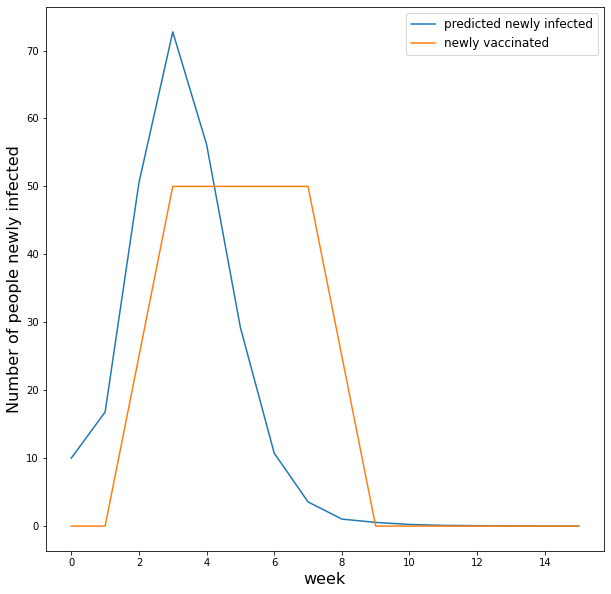

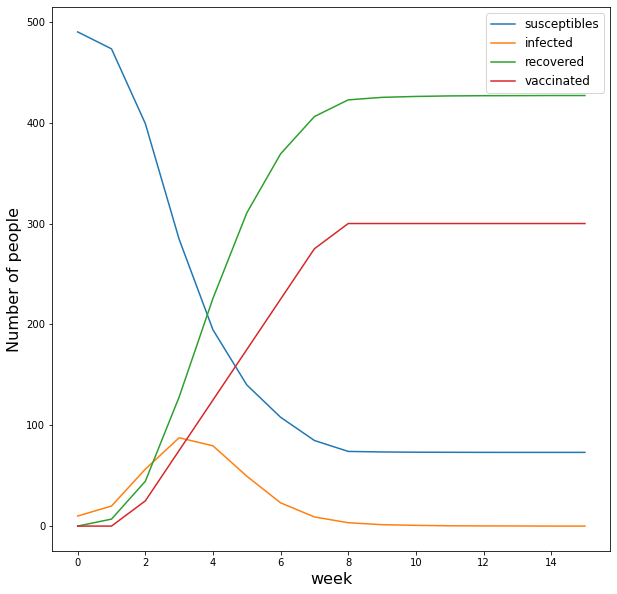

In [28]:
plot_newly_infected(hist_newly_infected, vaxxed = [5*vaxxed[0]] + (5*np.diff(vaxxed)).tolist())
plot_history_epidemics(history, vaxxed = list(5*np.array(vaxxed)))

# Problem 4

We now try to find the best parameters (k as average degree of the preferential attachment graph, beta and rho as epidemic parameters) that produce the best results in terms of newly infected per week with respect to the actual newly infected per week that happened in 2009 during 15 weeks of the H1N1 Influenza epidemic in Sweden. Note that we scale the data by a factor of $10^4$ in order to reduce the computational power required.

In [7]:
vaxxed = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] # the actual % of population vaccinated until week i
true_infected = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0] # the actual n. of infected each week
population_size = 934

In [8]:
import itertools
from sklearn.metrics import mean_squared_error
def find_population_parameters(n_simulations, vaxxed_per_week, starting_vaxxed, true_infected, population_size, k_0, beta_0, rho_0, delta_k, delta_b, delta_r, small_worlds=False, min_delta=False):
    delta_k = delta_k
    delta_b = delta_b
    delta_r = delta_r
    best_params = [k_0, beta_0, rho_0]
    ovr_best_params = [k_0, beta_0, rho_0]
    epoch = 0
    min_RMSE = np.inf
    ovr_best_RMSE = np.inf
    while epoch < 20:
        epoch +=1
        print(f'epoch {epoch}:')    
        params = np.array([[ovr_best_params[0], ovr_best_params[0] + delta_k, ovr_best_params[0] - delta_k],
                          [ovr_best_params[1], ovr_best_params[1] + delta_b, ovr_best_params[1] - delta_b],
                          [ovr_best_params[2], ovr_best_params[2] + delta_r, ovr_best_params[2] - delta_r]])
        
        counter = 0
        min_RMSE = ovr_best_RMSE
        for k, b, r in list(itertools.product(*params)): #generate all the possible combinations of parameters
            if k > 0 and b > 0 and r > 0 and b <=1 and r <=1: # only valid parameters  
                hist_newly_infected = np.zeros(16)
                for n_sims in range(n_simulations):
                    G = generate_preferential_attachment_graph(int(k), population_size)
                    _, h_ni = simulate_epidemics(n_weeks=15, beta=b, rho=r, G=G, 
                                starting_infected=true_infected[0], vaccinations=True, n_vax_per_week=vaxxed_per_week,
                                                           starting_vaxxed=starting_vaxxed)
                    hist_newly_infected = hist_newly_infected + h_ni
                hist_newly_infected = hist_newly_infected/n_simulations
                RMSE = mean_squared_error(true_infected[1:], hist_newly_infected[1:], squared=False) #calculate RMSE
                print(f"\t{RMSE} for {b,r,gp};")
                counter += 1
                if RMSE < min_RMSE: #save parameters that hold the best RMSE
                    min_RMSE = RMSE
                    best_params[0] = k
                    best_params[1] = b
                    best_params[2] = r
        print(f'\tmin_RMSE ({n_simulations} sims): {min_RMSE} for params {round(best_params[0], 4), round(best_params[1], 4), round(best_params[2], 4)} between {counter} different set of parameters.')
        #if no new parameters found, restrict the search
        if ovr_best_params[0] == best_params[0] and ovr_best_params[1] == best_params[1] and ovr_best_params[2] == best_params[2]:
            print(f'\t No new parameters found as best parameters.')
            delta_b = delta_b/2
            delta_r = delta_r/2
            if min_delta: # don't take steps smaller than 0.025 for beta and rho.
                if delta_b < 0.025:
                    delta_b = 0.025
                if delta_r < 0.025:
                    delta_r = 0.025
            delta_k = math.ceil(delta_k/2) #we want k to be positive do delta k to be at least 1
        if ovr_best_RMSE > min_RMSE:
            ovr_best_params[0] = best_params[0]
            ovr_best_params[1] = best_params[1]
            ovr_best_params[2] = best_params[2]
            ovr_best_RMSE = min_RMSE
        
        
    return ovr_best_params[0], ovr_best_params[1], ovr_best_params[2]

In [35]:
kappa_star, beta_star, rho_star = find_population_parameters(50, vaxxed_per_week = np.diff(vaxxed),
      true_infected = true_infected, population_size = population_size, k_0 = 10, beta_0 = 0.3,
       rho_0 = 0.6, delta_k = 3, delta_b = 0.2, delta_r = 0.2, starting_vaxxed=vaxxed[0], min_delta=True)
print(f'Best parameters: kappa = {kappa_star}, beta = {beta_star}, rho = {rho_star}.')

epoch 1:
	29.894852622706363 for (0.3, 0.6, 10.0);
	31.488576129553184 for (0.3, 0.8, 10.0);
	28.284020459145008 for (0.3, 0.39999999999999997, 10.0);
	70.21541787005661 for (0.5, 0.6, 10.0);
	66.50717976278952 for (0.5, 0.8, 10.0);
	68.30087730036855 for (0.5, 0.39999999999999997, 10.0);
	12.077379406698018 for (0.09999999999999998, 0.6, 10.0);
	12.344477847739585 for (0.09999999999999998, 0.8, 10.0);
	10.826192928880094 for (0.09999999999999998, 0.39999999999999997, 10.0);
	42.210741129085456 for (0.3, 0.6, 13.0);
	45.21913901583414 for (0.3, 0.8, 13.0);
	42.169026547929704 for (0.3, 0.39999999999999997, 13.0);
	83.2274329773543 for (0.5, 0.6, 13.0);
	76.75372303673615 for (0.5, 0.8, 13.0);
	70.11856054806982 for (0.5, 0.39999999999999997, 13.0);
	9.306701528110448 for (0.09999999999999998, 0.6, 13.0);
	11.268158086691306 for (0.09999999999999998, 0.8, 13.0);
	7.372326634109478 for (0.09999999999999998, 0.39999999999999997, 13.0);
	11.254415429806501 for (0.3, 0.6, 7.0);
	9.987214493

	12.212232119204636 for (0.049999999999999975, 0.35, 16.0);
	8.34643237157849 for (0.09999999999999998, 0.39999999999999997, 17.0);
	7.42440121042319 for (0.09999999999999998, 0.44999999999999996, 17.0);
	6.311819600294883 for (0.09999999999999998, 0.35, 17.0);
	21.537448316827135 for (0.14999999999999997, 0.39999999999999997, 17.0);
	23.236551666143004 for (0.14999999999999997, 0.44999999999999996, 17.0);
	20.437586289318347 for (0.14999999999999997, 0.35, 17.0);
	12.072701989750819 for (0.049999999999999975, 0.39999999999999997, 17.0);
	12.594163727695461 for (0.049999999999999975, 0.44999999999999996, 17.0);
	12.36527503400821 for (0.049999999999999975, 0.35, 17.0);
	6.390305157032801 for (0.09999999999999998, 0.39999999999999997, 15.0);
	6.935952710334752 for (0.09999999999999998, 0.44999999999999996, 15.0);
	6.749714068017992 for (0.09999999999999998, 0.35, 15.0);
	11.581315987399705 for (0.14999999999999997, 0.39999999999999997, 15.0);
	10.760097892987158 for (0.14999999999999997

	11.024331876958954 for (0.07499999999999998, 0.49999999999999994, 16.0);
	10.781444553800139 for (0.07499999999999998, 0.5249999999999999, 16.0);
	9.83496348069817 for (0.07499999999999998, 0.4749999999999999, 16.0);
	6.625834287091703 for (0.09999999999999998, 0.49999999999999994, 17.0);
	6.576765162296735 for (0.09999999999999998, 0.5249999999999999, 17.0);
	6.2392798729767955 for (0.09999999999999998, 0.4749999999999999, 17.0);
	12.535731330879743 for (0.12499999999999997, 0.49999999999999994, 17.0);
	9.848944444287756 for (0.12499999999999997, 0.5249999999999999, 17.0);
	12.976683705785542 for (0.12499999999999997, 0.4749999999999999, 17.0);
	9.062235191533414 for (0.07499999999999998, 0.49999999999999994, 17.0);
	10.180804159462715 for (0.07499999999999998, 0.5249999999999999, 17.0);
	8.401926763149827 for (0.07499999999999998, 0.4749999999999999, 17.0);
	6.5566800542144295 for (0.09999999999999998, 0.49999999999999994, 15.0);
	7.483455529811523 for (0.09999999999999998, 0.524999

RMSE:  6.067195947607648


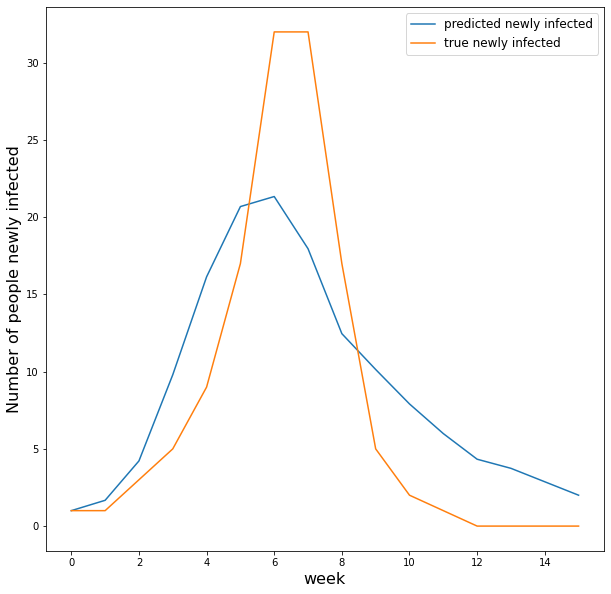

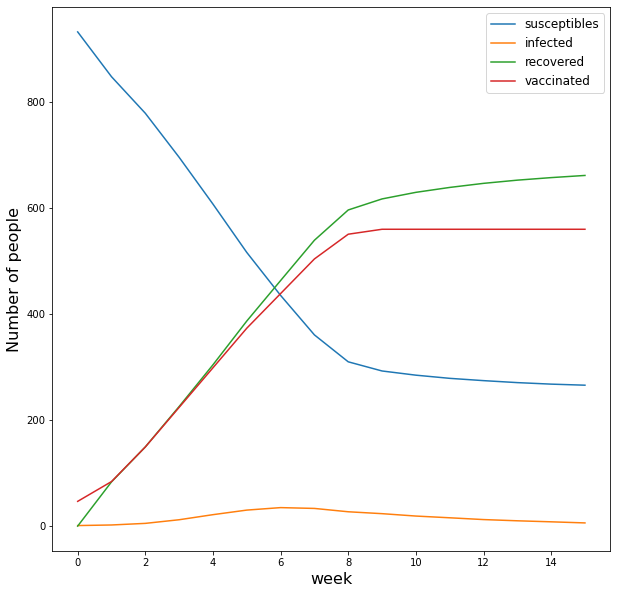

In [39]:
history = np.zeros((3, 16))
hist_newly_infected = np.zeros(16)
n_simulations = 100
for n in range(n_simulations):
    GPA = generate_preferential_attachment_graph(int(kappa_star), population_size)
    h, h_ni = simulate_epidemics(n_weeks=15, beta=beta_star,
              rho=rho_star, G=GPA, starting_infected=true_infected[0], vaccinations=True, n_vax_per_week= np.diff(vaxxed), 
                                                  starting_vaxxed=vaxxed[0])
    history = history + h
    hist_newly_infected = hist_newly_infected + h_ni
history = history/n_simulations
hist_newly_infected = hist_newly_infected/n_simulations
RMSE = mean_squared_error(true_infected[1:], hist_newly_infected[1:], squared=False)
print('RMSE: ', RMSE)
plot_newly_infected(hist_newly_infected, true_infected = true_infected)
plot_history_epidemics(history, list(9.34*np.array(vaxxed)))

In [20]:
kappa_star_2, beta_star_2, rho_star_2 = find_population_parameters(50, vaxxed_per_week = np.diff(vaxxed),
      true_infected = true_infected , population_size = population_size, k_0 = 14, beta_0 = 0.1,
       rho_0 = 0.5, delta_k = 3, delta_b = 0.2, delta_r = 0.2, starting_vaxxed=vaxxed[0])
print(f'Best parameters: kappa = {kappa_star_2}, beta = {beta_star_2}, rho = {rho_star_2}.')


epoch 1:
	8.149871164625855 for (0.1, 0.5, 14.0);
	10.529065802181439 for (0.1, 0.7, 14.0);
	7.739252332536178 for (0.1, 0.3, 14.0);
	59.996755467830646 for (0.30000000000000004, 0.5, 14.0);
	56.76947207786945 for (0.30000000000000004, 0.7, 14.0);
	53.1846972978757 for (0.30000000000000004, 0.3, 14.0);
	6.432606521983656 for (0.1, 0.5, 17.0);
	6.983842304443403 for (0.1, 0.7, 17.0);
	9.202992267011131 for (0.1, 0.3, 17.0);
	72.20678546138629 for (0.30000000000000004, 0.5, 17.0);
	65.6963670228423 for (0.30000000000000004, 0.7, 17.0);
	70.01796283811748 for (0.30000000000000004, 0.3, 17.0);
	10.132286349421173 for (0.1, 0.5, 11.0);
	11.507752749052846 for (0.1, 0.7, 11.0);
	10.149732344582624 for (0.1, 0.3, 11.0);
	39.356836254963376 for (0.30000000000000004, 0.5, 11.0);
	36.64206034964009 for (0.30000000000000004, 0.7, 11.0);
	32.32858549333701 for (0.30000000000000004, 0.3, 11.0);
	min_RMSE (50 sims): 6.432606521983656 for params (17.0, 0.1, 0.5) between 18 different set of parameters

	8.137508218121809 for (0.1125, 0.5625, 17.0);
	7.890762531804727 for (0.1125, 0.5375000000000001, 17.0);
	8.320318904144639 for (0.08750000000000001, 0.55, 17.0);
	7.48370140149022 for (0.08750000000000001, 0.5625, 17.0);
	7.476915585097017 for (0.08750000000000001, 0.5375000000000001, 17.0);
	7.636412770404701 for (0.1, 0.55, 15.0);
	6.915090744162365 for (0.1, 0.5625, 15.0);
	8.065682033570793 for (0.1, 0.5375000000000001, 15.0);
	6.233413190219304 for (0.1125, 0.55, 15.0);
	6.0909046947066905 for (0.1125, 0.5625, 15.0);
	6.189935917815843 for (0.1125, 0.5375000000000001, 15.0);
	9.454329519678627 for (0.08750000000000001, 0.55, 15.0);
	10.243745408784816 for (0.08750000000000001, 0.5625, 15.0);
	9.649418635337572 for (0.08750000000000001, 0.5375000000000001, 15.0);
	min_RMSE (50 sims): 5.418961770179474 for params (16.0, 0.1, 0.55) between 27 different set of parameters.
	 No new parameters found as best parameters.
epoch 8:
	6.195706039938735 for (0.1, 0.55, 16.0);
	8.039225501667

	5.6770109506088975 for (0.10312500000000001, 0.5515625000000001, 17.0);
	6.620580035012038 for (0.10312500000000001, 0.5484375, 17.0);
	5.798238813064993 for (0.1046875, 0.55, 17.0);
	5.4811069441613105 for (0.1046875, 0.5515625000000001, 17.0);
	6.735470287960596 for (0.1046875, 0.5484375, 17.0);
	5.867687789922023 for (0.10156250000000001, 0.55, 17.0);
	6.226827977924769 for (0.10156250000000001, 0.5515625000000001, 17.0);
	6.779777774135865 for (0.10156250000000001, 0.5484375, 17.0);
	6.866797409758545 for (0.10312500000000001, 0.55, 15.0);
	7.967468857799195 for (0.10312500000000001, 0.5515625000000001, 15.0);
	6.837151453639153 for (0.10312500000000001, 0.5484375, 15.0);
	6.862813805818525 for (0.1046875, 0.55, 15.0);
	7.413107310703118 for (0.1046875, 0.5515625000000001, 15.0);
	7.869505702393258 for (0.1046875, 0.5484375, 15.0);
	6.384159563586527 for (0.10156250000000001, 0.55, 15.0);
	6.337844007757423 for (0.10156250000000001, 0.5515625000000001, 15.0);
	7.084619961578743 fo

	6.97976312874107 for (0.10371093750000002, 0.5498046875, 15.0);
	6.881633527005054 for (0.10332031250000001, 0.55, 15.0);
	8.101433617988032 for (0.10332031250000001, 0.5501953125000001, 15.0);
	8.020310883417592 for (0.10332031250000001, 0.5498046875, 15.0);
	min_RMSE (50 sims): 5.115299926038876 for params (16.0, 0.1035, 0.55) between 27 different set of parameters.
	 No new parameters found as best parameters.
epoch 17:
	5.437075194133944 for (0.10351562500000001, 0.55, 16.0);
	6.399352050533449 for (0.10351562500000001, 0.5500976562500001, 16.0);
	5.8879923007196036 for (0.10351562500000001, 0.54990234375, 16.0);
	7.47544067820308 for (0.10361328125000001, 0.55, 16.0);
	6.264628746648387 for (0.10361328125000001, 0.5500976562500001, 16.0);
	6.048653844727216 for (0.10361328125000001, 0.54990234375, 16.0);
	6.5732508446480775 for (0.10341796875000002, 0.55, 16.0);
	6.093504738654103 for (0.10341796875000002, 0.5500976562500001, 16.0);
	7.2632756613895175 for (0.10341796875000002, 0

RMSE:  5.728240567573956


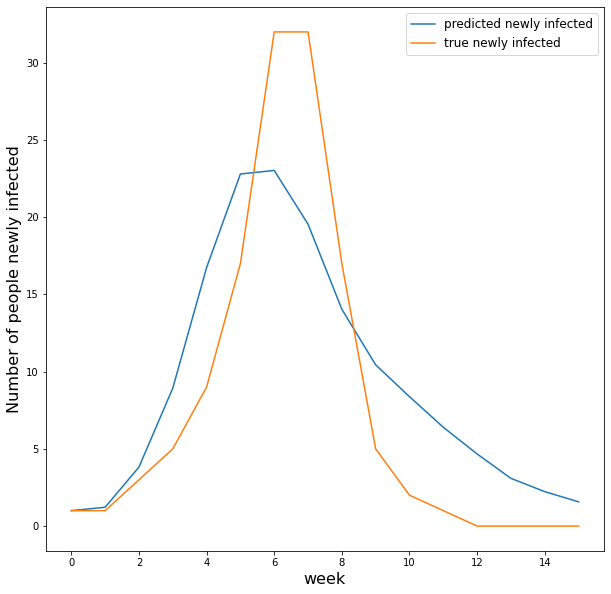

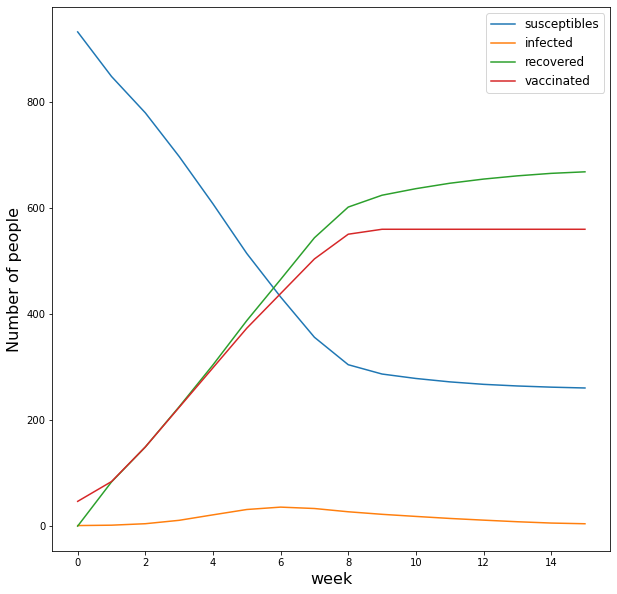

In [54]:
history = np.zeros((3, 16))
hist_newly_infected = np.zeros(16)
n_simulations = 100
for n in range(n_simulations):
    GPA = generate_preferential_attachment_graph(int(17), population_size)
    h, h_ni = simulate_epidemics(n_weeks=15, beta=0.103466796875,
              rho=0.55, G=GPA, starting_infected=true_infected[0], vaccinations=True, n_vax_per_week= np.diff(vaxxed), 
                                                  starting_vaxxed=vaxxed[0])
    history = history + h
    hist_newly_infected = hist_newly_infected + h_ni
history = history/n_simulations
hist_newly_infected = hist_newly_infected/n_simulations
RMSE = mean_squared_error(true_infected[1:], hist_newly_infected[1:], squared=False)
print('RMSE: ', RMSE)
plot_newly_infected(hist_newly_infected, true_infected = true_infected)
plot_history_epidemics(history, list(9.34*np.array(vaxxed)))

We now consider as random graph the Small World model and we rerun the same simulations as done above.

In [12]:
def generate_small_worlds_graph(population_size, p, k):
    GSN = nx.cycle_graph(population_size) #start from a cycle graph
    for n in range(population_size):
        for i in range(1, int(k/2+1)): #add connections from n to its k closest neighbours
            GSN.add_edge(n,((n+i) % population_size))
            GSN.add_edge(n,((n-i) % population_size))
    for i in range(population_size):
        for j in range(population_size):
            if i != j and np.random.rand() < p: #add link to 2 random nodes with probability p
                GSN.add_edge(i,j)
    return GSN

In [13]:
def find_small_worlds_parameters(n_simulations, vaxxed_per_week, starting_vaxxed, true_infected, population_size, p_0, k_0,
                                beta_0, rho_0, delta_p, delta_k, delta_b, delta_r, min_delta=True):
    delta_k = delta_k
    delta_b = delta_b
    delta_r = delta_r
    delta_p = delta_p
    best_params = [k_0, beta_0, rho_0, p_0]
    ovr_best_params = [k_0, beta_0, rho_0, p_0]
    epoch = 0
    min_RMSE = np.inf
    ovr_best_RMSE = np.inf
    while epoch < 10:
        epoch +=1
        print(f'epoch {epoch}:')    
        params = np.array([[ovr_best_params[0], ovr_best_params[0] + delta_k, ovr_best_params[0] - delta_k],
                          [ovr_best_params[1], ovr_best_params[1] + delta_b, ovr_best_params[1] - delta_b],
                          [ovr_best_params[2], ovr_best_params[2] + delta_r, ovr_best_params[2] - delta_r],
                          [ovr_best_params[3], ovr_best_params[3] + delta_p, ovr_best_params[3] - delta_p]])
        
        counter = 0
        min_RMSE = ovr_best_RMSE
        for k, b, r, p in list(itertools.product(*params)):
            if k > 0 and b > 0 and r > 0 and p > 0 and b <=1 and r <=1 and p<=1: # only valid parameters  
                hist_newly_infected = np.zeros(16)
                for n_sims in range(n_simulations):
                    G = generate_small_worlds_graph(population_size, p, int(k))
                    _, h_ni = simulate_epidemics(n_weeks=15, beta=b, rho=r, G=G, 
                                starting_infected=true_infected[0], vaccinations=True, n_vax_per_week=vaxxed_per_week,
                                                           starting_vaxxed=starting_vaxxed)
                    hist_newly_infected = hist_newly_infected + h_ni
                hist_newly_infected = hist_newly_infected/n_simulations
                RMSE = mean_squared_error(true_infected[1:], hist_newly_infected[1:], squared=False)
                print(f"\t{RMSE} for {b,r,k,p};")
                counter += 1
                if RMSE < min_RMSE:
                    min_RMSE = RMSE
                    best_params[0] = k
                    best_params[1] = b
                    best_params[2] = r
                    best_params[3] = p
        print(f'\tmin_RMSE ({n_simulations} sims): {min_RMSE} for params {round(best_params[0], 4), round(best_params[1], 4), round(best_params[2], 4), round(best_params[3], 4)} between {counter} different set of parameters.')
        if ovr_best_params[0] == best_params[0] and ovr_best_params[1] == best_params[1] and ovr_best_params[2] == best_params[2] and ovr_best_params[3] == best_params[3]:
            print(f'\t No new parameters found as best parameters.')
            delta_b = delta_b/2
            delta_r = delta_r/2
            delta_p = delta_p/2
            if min_delta: # don't take steps smaller than 0.025 for beta and rho and than 0.0025 for p.
                if delta_b < 0.025:
                    delta_b = 0.025
                if delta_r < 0.025:
                    delta_r = 0.025
                if delta_p < 0.0025:
                    delta_p = 0.0025
        if ovr_best_RMSE > min_RMSE:
            ovr_best_params[0] = best_params[0]
            ovr_best_params[1] = best_params[1]
            ovr_best_params[2] = best_params[2]
            ovr_best_params[3] = best_params[3]
            ovr_best_RMSE = min_RMSE
        
        
    return ovr_best_params[0], ovr_best_params[1], ovr_best_params[2], ovr_best_params[3]

In [16]:
k_star_4, beta_star_4, rho_star_4, p_star_4 = find_small_worlds_parameters(50, vaxxed_per_week = np.diff(vaxxed),
      true_infected = true_infected , population_size = population_size, k_0 = 6, beta_0 = 0.1,
       rho_0 = 0.5, p_0 = 0.02, delta_k = 2, delta_b = 0.2, delta_r = 0.2, delta_p = 0.01, starting_vaxxed=vaxxed[0])
print(f'Best parameters: k = {k_star_4}, beta = {beta_star_4}, rho = {rho_star_4}, p = {p_star_4}.')

epoch 1:
	33.11744112498227 for (0.1, 0.5, 6.0, 0.02);
	68.11082283063878 for (0.1, 0.5, 6.0, 0.03);
	10.113142604222158 for (0.1, 0.5, 6.0, 0.01);
	34.52162066493016 for (0.1, 0.7, 6.0, 0.02);
	69.90037539241116 for (0.1, 0.7, 6.0, 0.03);
	7.507134384481649 for (0.1, 0.7, 6.0, 0.01);
	49.57642800094954 for (0.1, 0.3, 6.0, 0.02);
	69.46758994907866 for (0.1, 0.3, 6.0, 0.03);
	15.177830323644198 for (0.1, 0.3, 6.0, 0.01);
	114.0599330176903 for (0.30000000000000004, 0.5, 6.0, 0.02);
	117.89615385301308 for (0.30000000000000004, 0.5, 6.0, 0.03);
	84.28274572334877 for (0.30000000000000004, 0.5, 6.0, 0.01);
	113.32614090903006 for (0.30000000000000004, 0.7, 6.0, 0.02);
	120.86585555896255 for (0.30000000000000004, 0.7, 6.0, 0.03);
	81.2401816836964 for (0.30000000000000004, 0.7, 6.0, 0.01);
	118.35262103843188 for (0.30000000000000004, 0.3, 6.0, 0.02);
	117.9400591260945 for (0.30000000000000004, 0.3, 6.0, 0.03);
	83.37450369667376 for (0.30000000000000004, 0.3, 6.0, 0.01);
	38.5975861075

	14.608435919016108 for (0.2, 0.7999999999999999, 8.0, 0.005);
	5.380104088212421 for (0.1, 0.8999999999999999, 10.0, 0.01);
	24.02771788303389 for (0.1, 0.8999999999999999, 10.0, 0.015);
	11.867875968344126 for (0.1, 0.8999999999999999, 10.0, 0.005);
	6.147409210390991 for (0.1, 0.9999999999999999, 10.0, 0.01);
	17.040932681830146 for (0.1, 0.9999999999999999, 10.0, 0.015);
	12.90353026630051 for (0.1, 0.9999999999999999, 10.0, 0.005);
	8.731982592744904 for (0.1, 0.7999999999999999, 10.0, 0.01);
	24.787841105402194 for (0.1, 0.7999999999999999, 10.0, 0.015);
	11.557120748698614 for (0.1, 0.7999999999999999, 10.0, 0.005);
	59.900550693072375 for (0.2, 0.8999999999999999, 10.0, 0.01);
	80.91364186588068 for (0.2, 0.8999999999999999, 10.0, 0.015);
	19.9919177002441 for (0.2, 0.8999999999999999, 10.0, 0.005);
	58.98247129444476 for (0.2, 0.9999999999999999, 10.0, 0.01);
	81.6721609036192 for (0.2, 0.9999999999999999, 10.0, 0.015);
	13.919940612900138 for (0.2, 0.9999999999999999, 10.0, 0

	11.966556731157048 for (0.15000000000000002, 0.9999999999999999, 4.0, 0.005);
	5.8582431951339595 for (0.15000000000000002, 0.9999999999999999, 4.0, 0.0075);
	13.529047268747345 for (0.15000000000000002, 0.9999999999999999, 4.0, 0.0025);
	11.919093925294824 for (0.15000000000000002, 0.9499999999999998, 4.0, 0.005);
	6.380472291818739 for (0.15000000000000002, 0.9499999999999998, 4.0, 0.0075);
	13.476229937684105 for (0.15000000000000002, 0.9499999999999998, 4.0, 0.0025);
	min_RMSE (50 sims): 5.241442549527753 for params (6.0, 0.2, 1.0, 0.005) between 54 different set of parameters.
	 No new parameters found as best parameters.
epoch 7:
	6.962421034860409 for (0.2, 0.9999999999999999, 6.0, 0.005);
	21.277863301249653 for (0.2, 0.9999999999999999, 6.0, 0.0075);
	12.391158137962728 for (0.2, 0.9999999999999999, 6.0, 0.0025);
	6.370498672265251 for (0.2, 0.9749999999999999, 6.0, 0.005);
	25.352067108357584 for (0.2, 0.9749999999999999, 6.0, 0.0075);
	12.204994606034585 for (0.2, 0.9749999

	12.990807005981834 for (0.17500000000000002, 0.9749999999999999, 4.0, 0.0025);
	min_RMSE (50 sims): 5.241442549527753 for params (6.0, 0.2, 1.0, 0.005) between 54 different set of parameters.
	 No new parameters found as best parameters.
epoch 9:
	6.611156227670518 for (0.2, 0.9999999999999999, 6.0, 0.005);
	22.558853398758252 for (0.2, 0.9999999999999999, 6.0, 0.0075);
	12.292240370792191 for (0.2, 0.9999999999999999, 6.0, 0.0025);
	5.570831176763482 for (0.2, 0.9749999999999999, 6.0, 0.005);
	21.93730156605411 for (0.2, 0.9749999999999999, 6.0, 0.0075);
	11.82375687616532 for (0.2, 0.9749999999999999, 6.0, 0.0025);
	9.906825929630541 for (0.225, 0.9999999999999999, 6.0, 0.005);
	35.73989852625028 for (0.225, 0.9999999999999999, 6.0, 0.0075);
	10.248850342030236 for (0.225, 0.9999999999999999, 6.0, 0.0025);
	11.521872532998561 for (0.225, 0.9749999999999999, 6.0, 0.005);
	37.95029837388194 for (0.225, 0.9749999999999999, 6.0, 0.0075);
	10.76434237037575 for (0.225, 0.9749999999999999

RMSE:  6.04289720801758


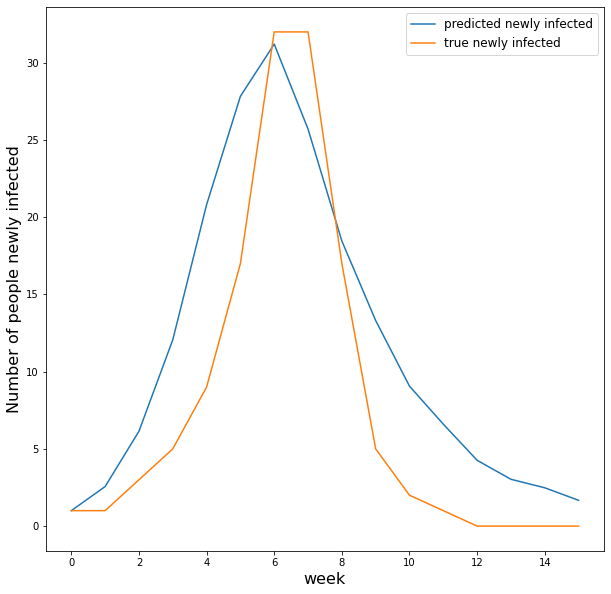

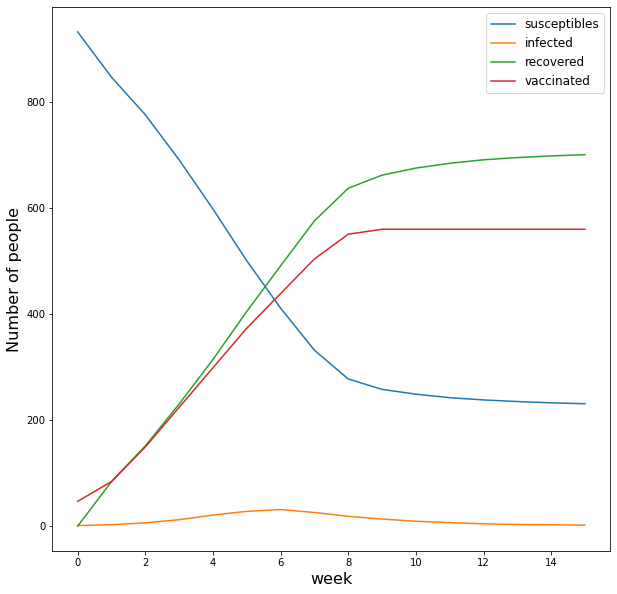

In [17]:
history = np.zeros((3, 16))
hist_newly_infected = np.zeros(16)
n_simulations = 100
for n in range(n_simulations):
    GSW = generate_small_worlds_graph(population_size, p_star_4, k_star_4)
    h, h_ni = simulate_epidemics(n_weeks=15, beta=beta_star_4,
              rho=rho_star_4, G=GSW, starting_infected=true_infected[0], vaccinations=True, n_vax_per_week= np.diff(vaxxed), 
                                                  starting_vaxxed=vaxxed[0])
    history = history + h
    hist_newly_infected = hist_newly_infected + h_ni
history = history/n_simulations
hist_newly_infected = hist_newly_infected/n_simulations
RMSE = mean_squared_error(true_infected[1:], hist_newly_infected[1:], squared=False)
print('RMSE: ', RMSE)
plot_newly_infected(hist_newly_infected, true_infected = true_infected)
plot_history_epidemics(history, list(9.34*np.array(vaxxed)))